In [1]:
import tensorflow as tf
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np



# 0x0C. Neural Style Transfer

In [2]:
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        """Initaializer"""

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()

    @staticmethod
    def scale_image(image):
        """Rescales the image such that its pixels values are between 0 and 1
        and its largest side is 512 pixels."""
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize(image, new_shape, 'bicubic') / 255, 0, 1)
        return image
        
    def load_model(self):
        """Creates the model used to calculate the cost"""
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        """Calculates the gram matrices"""
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        """Extracts the features used to calculate neural style cost"""
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        

    def layer_style_cost(self, style_output, gram_target):
        """Calculates the style cost for a single layer"""
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))

    def style_cost(self, style_outputs):
        """Calculates the style cost for generated image"""

        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style
 
    def content_cost(self, content_output):
        """Calculates the content cost for the generated image"""
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)

    def total_cost(self, generated_image): 
        """Calculates the total cost for the generated image"""
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        preprocessed = tf.keras.applications.vgg19.preprocess_input(generated_image * 255)
        model_outputs = self.model(preprocessed)
        style_outputs = [style_layer for style_layer in model_outputs[:-1]]
        content_output = model_outputs[-1]

        J_style = self.style_cost(style_outputs)
        J_content = self.content_cost(content_output)
        J = (self.alpha * J_content) + (self.beta * J_style)
        return J, J_content, J_style

    def compute_grads(self, generated_image):
        """Calculates the gradients for the generated image"""
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        with tf.GradientTape() as tape:
            tape.watch(generated_image)
            J, J_content, J_style = self.total_cost(generated_image)
        grads = tape.gradient(J, generated_image)
        return grads, J, J_content, J_style


    def generate_image(self, iterations=1000, step=None, lr=0.01, beta1=0.9, beta2=0.99):
        if type(iterations) is not int:
            raise TypeError('iterations must be an integer')
        if iterations < 1:
            raise ValueError('iterations must be positive')
        if step is not None and type(step) is not int:
            raise TypeError('step must be an integer')
        if step is not None and not 0 < step < iterations:
            raise ValueError('step must be positive and less than iterations')
        if type(lr) is not float and type(lr) is not int:
            raise TypeError('lr must be a number')
        if lr <= 0:
            raise ValueError('lr must be positive')
        if type(beta1) is not float:
            raise TypeError('beta1 must be a float')
        if not 0 <= beta1 <= 1:
            raise ValueError('beta1 must be in the range [0, 1]')
        if type(beta2) is not float:
            raise TypeError('beta2 must be a float')
        if not 0 <= beta2 <= 1:
            raise ValueError('beta2 must be in the range [0, 1]')
        generated_image = tf.Variable(self.content_image)
        optimizer = tf.keras.optimizers.Adam(lr, beta1, beta2)
        # optimizer = tf.train.AdamOptimizer(lr, beta1, beta2) tf-V1
        best_cost = np.inf
        best_image = None
        for i in range(iterations):
            grads, J, J_content, J_style = self.compute_grads(generated_image)
            if step is not None and i % step == 0:
                print("Cost at iteration {}: {}, content {}, style {}".format(i, J, J_content, J_style))
            if J < best_cost:
                best_cost = J.numpy()
                best_image = generated_image.numpy()[0]
            optimizer.apply_gradients([(grads, generated_image)])
            generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
            
        _, J, J_content, J_style = self.compute_grads(generated_image)
        if J < best_cost:
            best_cost = J.numpy()
            best_image = generated_image.numpy()[0]
        if step is not None:
            print("Cost at iteration {}: {}, content {}, style {}".format(iterations, J, J_content, J_style))
        return best_image, best_cost

# 0. Initialize


['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
block5_conv2
<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 320, 512, 3) 0.0 1.0
<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 343, 512, 3) 0.0 1.0
10000.0
1
True


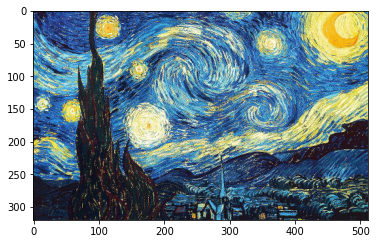

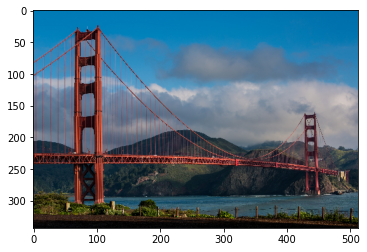

In [3]:
style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

print(NST.style_layers)
print(NST.content_layer)
nst = NST(style_image, content_image)
scaled_style = nst.scale_image(style_image)
scaled_content = nst.scale_image(content_image)
print(type(nst.style_image), nst.style_image.shape, np.min(nst.style_image),
            np.max(nst.style_image))
print(type(nst.content_image), nst.content_image.shape, np.min(nst.content_image),
            np.max(nst.content_image))
print(nst.alpha)
print(nst.beta)
print(tf.executing_eagerly())
assert(np.array_equal(scaled_style, nst.style_image))
assert(np.array_equal(scaled_content, nst.content_image))

plt.imshow(nst.style_image[0])
plt.show()
plt.imshow(nst.content_image[0])
plt.show()


# 1. Load the Model 

In [4]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

nst = NST(style_image, content_image)
nst.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0   

# 2. Gram Matrix 

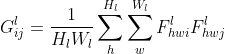

In [5]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
input_layer = tf.constant(np.random.randn(1, 28, 30, 3), dtype=tf.float32)
gram_matrix = nst.gram_matrix(input_layer)
print(gram_matrix)

tf.Tensor(
[[[ 0.9555436  -0.00985771  0.01343341]
  [-0.00985771  0.99867874  0.03569118]
  [ 0.01343341  0.03569118  0.98452365]]], shape=(1, 3, 3), dtype=float32)


# 3. Extract Features 

In [6]:
tf.random.set_seed(1)
style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
print(nst.gram_style_features)
print(nst.content_feature)


[<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 5756.8267 ,  2460.2236 ,  1735.3108 , ...,  1802.0953 ,
          1436.8545 ,  2283.8472 ],
        [ 2460.2236 ,  6018.7217 ,  2516.9497 , ...,  1394.7166 ,
          1890.9333 ,  1566.7012 ],
        [ 1735.3108 ,  2516.9497 ,  1825.6233 , ...,   268.12772,
          1492.1879 ,  1712.2865 ],
        ...,
        [ 1802.0953 ,  1394.7166 ,   268.12772, ..., 11043.293  ,
          1228.2603 ,   722.04755],
        [ 1436.8545 ,  1890.9333 ,  1492.1879 , ...,  1228.2603 ,
          2858.2073 ,  2463.2036 ],
        [ 2283.8472 ,  1566.7012 ,  1712.2865 , ...,   722.04755,
          2463.2036 ,  2920.749  ]]], dtype=float32)>, <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1.5858041e+03, 2.0782605e+02, 4.5135851e+00, ...,
         1.2954677e+03, 9.5775208e+02, 3.6327881e+02],
        [2.0782605e+02, 1.9686490e+04, 6.1289463e+03, ...,
         2.3898402e+04, 1.7583596e+04, 8.3043945e+03],
        [4.5135851e

# 4. Layer Style Cost

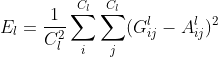

In [7]:

tf.random.set_seed(1)
style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

nst = NST(style_image, content_image)

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

vgg19 = tf.keras.applications.vgg19
preprocecced = vgg19.preprocess_input(nst.content_image * 255)
outputs = nst.model(preprocecced)
layer_style_cost = nst.layer_style_cost(outputs[0], nst.gram_style_features[0])
print(layer_style_cost)



tf.Tensor(1213068.2, shape=(), dtype=float32)


# 5. Style Cost


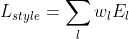

In [8]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
vgg19 = tf.keras.applications.vgg19
preprocecced = vgg19.preprocess_input(nst.content_image * 255)
style_outputs = nst.model(preprocecced)[:-1]
style_cost = nst.style_cost(style_outputs)
print(style_cost)


tf.Tensor(1382607000.0, shape=(), dtype=float32)


# 6-content loss

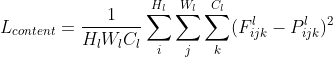

In [9]:
style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
generated_image = np.random.uniform(size=nst.content_image.shape)
generated_image = generated_image.astype('float32')
vgg19 = tf.keras.applications.vgg19
preprocecced = vgg19.preprocess_input(generated_image * 255)
outputs = nst.model(preprocecced)
content_output = outputs[-1]
content_cost = nst.content_cost(content_output)
print(content_cost)

tf.Tensor(109.36226, shape=(), dtype=float32)


# 7. Total Cost


image.png

In [10]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
generated_image = np.random.uniform(size=nst.content_image.shape)
generated_image = tf.cast(generated_image, tf.float32)
J_total, J_content, J_style = nst.total_cost(generated_image)
print(J_total)
print(J_content)
print(J_style)

tf.Tensor(1553920500.0, shape=(), dtype=float32)
tf.Tensor(109.36226, shape=(), dtype=float32)
tf.Tensor(1552826900.0, shape=(), dtype=float32)


#8. Compute Gradients


In [11]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  
  
nst = NST(style_image, content_image)
generated_image = tf.Variable(nst.content_image)
grads, J_total, J_content, J_style = nst.compute_grads(generated_image)
print(J_total)
print(J_content)
print(J_style)
print(grads)
    

tf.Tensor(1382607000.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1382607000.0, shape=(), dtype=float32)
tf.Tensor(
[[[[-30281.71     -31185.508     -5514.8643  ]
   [-47544.19     -49884.914     -6556.8833  ]
   [-47072.934    -49907.17       -195.8297  ]
   ...
   [-43909.48     -23380.164     -2821.0798  ]
   [-49770.707    -35227.855     -9398.801   ]
   [-24558.297    -16142.871       413.78357 ]]

  [[-42368.867    -40488.79      -4633.436   ]
   [-57778.5      -56196.41       3928.6265  ]
   [-61378.676    -62088.875     10039.891   ]
   ...
   [-21626.396     21401.855     35472.125   ]
   [-47766.54     -17765.36      11174.26    ]
   [-29687.588    -13436.831      8099.75    ]]

  [[-20770.01     -12154.943     15716.19    ]
   [-28302.965    -18114.117     32193.244   ]
   [-34254.992    -29397.412     37171.457   ]
   ...
   [ 16380.448     68325.96      73827.39    ]
   [-21376.861     13775.224     40715.66    ]
   [-17080.176      1779.73

# 9. Generate Image

Cost at iteration 0: 1382606976.0, content 0.0, style 1382606976.0
Cost at iteration 100: 52109984.0, content 121.86367797851562, style 50891348.0
Cost at iteration 200: 21112214.0, content 130.38821411132812, style 19808332.0
Cost at iteration 300: 11242602.0, content 130.19998168945312, style 9940602.0
Cost at iteration 400: 7095826.0, content 127.29837799072266, style 5822842.0
Cost at iteration 500: 4966790.0, content 122.17029571533203, style 3745087.25
Cost at iteration 600: 3672149.5, content 115.35269165039062, style 2518622.5
Cost at iteration 700: 2824957.0, content 107.55415344238281, style 1749415.375
Cost at iteration 800: 2264521.5, content 99.61248779296875, style 1268396.75
Cost at iteration 900: 1908920.75, content 92.9481430053711, style 979439.375
Cost at iteration 1000: 1709097.25, content 87.51573181152344, style 833939.9375
Cost at iteration 1100: 1555386.375, content 82.97122955322266, style 725674.0625
Cost at iteration 1200: 1425674.0, content 79.28593444824219

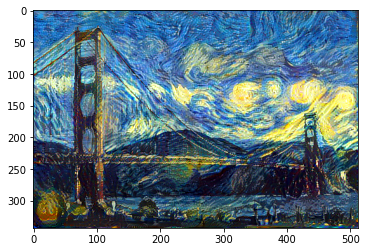

In [12]:
style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
image, cost = nst.generate_image(iterations=2000, step=100, lr=0.002)
print("Best cost:", cost)
plt.imshow(image)
plt.show()

# 10. Variational Cost:

In [13]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf

class NST:
    
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1, var=10):
        if type(style_image) is not np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError('style_image must be a numpy.ndarray with shape (h, w, 3)')
        if type(content_image) is not np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError('content_image must be a numpy.ndarray with shape (h, w, 3)')
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')
        if (type(var) is not int and type(var) is not float) or var < 0:
            raise TypeError('var must be a non-negative number')
        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.var = var
        self.load_model()
        self.generate_features()

    @staticmethod
    def scale_image(image):
        if type(image) is not np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError('image must be a numpy.ndarray with shape (h, w, 3)')
        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize(image, new_shape, 'bicubic') / 255, 0, 1)
        return image

    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model

    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]

    def layer_style_cost(self, style_output, gram_target):
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))
        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))

    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style

    def content_cost(self, content_output):
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)

    @staticmethod
    def variational_cost(image):
        if not (isinstance(image, tf.Tensor) or isinstance(image, tf.Variable)) or not 3 <= image.shape.ndims <= 4:
            raise TypeError('image must be a tensor of rank 3 or 4')
        return tf.reduce_sum(tf.image.total_variation(image))

    def total_cost(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        preprocessed = tf.keras.applications.vgg19.preprocess_input(generated_image * 255)
        model_outputs = self.model(preprocessed)
        style_outputs = [style_layer for style_layer in model_outputs[:-1]]
        content_output = model_outputs[-1]

        J_style = self.style_cost(style_outputs)
        J_content = self.content_cost(content_output)
        J_var = self.variational_cost(generated_image)
        J = (self.alpha * J_content) + (self.beta * J_style) + (self.var * J_var)
        return J, J_content, J_style, J_var

    def compute_grads(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        with tf.GradientTape() as tape:
            tape.watch(generated_image)
            J, J_content, J_style, J_var = self.total_cost(generated_image)
        grads = tape.gradient(J, generated_image)
        return grads, J, J_content, J_style, J_var

    def generate_image(self, iterations=1000, step=None, lr=0.01, beta1=0.9, beta2=0.99):
        if type(iterations) is not int:
            raise TypeError('iterations must be an integer')
        if iterations < 1:
            raise ValueError('iterations must be positive')
        if step is not None and type(step) is not int:
            raise TypeError('step must be an integer')
        if step is not None and not 0 < step < iterations:
            raise ValueError('step must be positive and less than iterations')
        if type(lr) is not float and type(lr) is not int:
            raise TypeError('lr must be a number')
        if lr <= 0:
            raise ValueError('lr must be positive')
        if type(beta1) is not float:
            raise TypeError('beta1 must be a float')
        if not 0 <= beta1 <= 1:
            raise ValueError('beta1 must be in the range [0, 1]')
        if type(beta2) is not float:
            raise TypeError('beta2 must be a float')
        if not 0 <= beta2 <= 1:
            raise ValueError('beta2 must be in the range [0, 1]')
        generated_image = tf.Variable(self.content_image)
        optimizer = tf.keras.optimizers.Adam(lr, beta1, beta2)
        best_cost = np.inf
        best_image = None
        for i in range(iterations):
            grads, J, J_content, J_style, J_var = self.compute_grads(generated_image)
            if step is not None and i % step == 0:
                print("Cost at iteration {}: {}, content {}, style {}, var {}".format(i, J, J_content, J_style, J_var))
            if J < best_cost:
                best_cost = J.numpy()
                best_image = generated_image.numpy()[0]
            optimizer.apply_gradients([(grads, generated_image)])
            generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
            
        _, J, J_content, J_style, J_var = self.compute_grads(generated_image)
        if J < best_cost:
            best_cost = J.numpy()
            best_image = generated_image.numpy()[0]
        if step is not None:
            print("Cost at iteration {}: {}, content {}, style {}, var {}".format(iterations, J, J_content, J_style, J_var))
        return best_image, best_cost


Cost at iteration 0: 1382946432.0, content 0.0, style 1382606976.0, var 33940.97265625
Cost at iteration 100: 52769364.0, content 121.85317993164062, style 50917724.0, var 63310.91796875
Cost at iteration 200: 21864504.0, content 130.35787963867188, style 19844000.0, var 71692.515625
Cost at iteration 300: 12059023.0, content 130.12815856933594, style 9979339.0, var 77840.15625
Cost at iteration 400: 7951777.5, content 127.17933654785156, style 5855083.5, var 82490.0390625
Cost at iteration 500: 5850959.5, content 122.05589294433594, style 3774114.5, var 85628.609375
Cost at iteration 600: 4569256.0, content 115.20490264892578, style 2543817.75, var 87338.90625
Cost at iteration 700: 3720996.0, content 107.36771392822266, style 1770470.0, var 87684.9140625
Cost at iteration 800: 3152360.5, content 99.6443099975586, style 1289037.25, var 86688.015625
Cost at iteration 900: 2780828.0, content 93.10719299316406, style 1002263.8125, var 84749.21875
Cost at iteration 1000: 2542256.25, conte

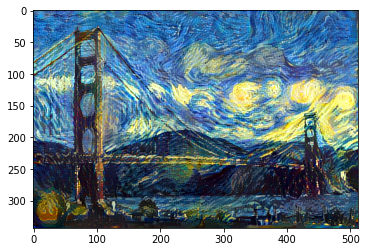

In [14]:

style_image = mpimg.imread("starry_night.jpg")
content_image = mpimg.imread("golden_gate.jpg")

# Reproducibility
seed=31415
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

nst = NST(style_image, content_image)
generated_image, cost = nst.generate_image(iterations=2000, step=100, lr=0.002)
print("Best cost:", cost)
plt.imshow(generated_image)
plt.show()


# test

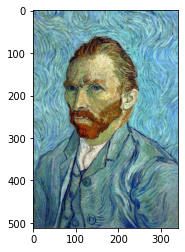

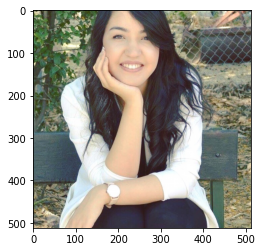

Cost at iteration 0: 452383744.0, content 0.0, style 451871296.0, var 51243.8359375
Cost at iteration 100: 13633667.0, content 84.0802993774414, style 11970458.0, var 82240.6015625
Cost at iteration 200: 7830245.0, content 81.29078674316406, style 6146675.0, var 87066.171875
Cost at iteration 300: 5490648.0, content 75.89277648925781, style 3845472.0, var 88624.78125
Cost at iteration 400: 4083021.25, content 69.28237915039062, style 2511064.5, var 87913.3046875
Cost at iteration 500: 3121810.25, content 62.805118560791016, style 1638377.25, var 85538.1796875
Cost at iteration 600: 2474760.5, content 56.75814437866211, style 1089983.5, var 81719.5390625
Cost at iteration 700: 2051050.875, content 51.511714935302734, style 765372.625, var 77056.109375
Cost at iteration 800: 1790336.375, content 47.56583023071289, style 587495.3125, var 72718.2734375
Cost at iteration 900: 1614435.75, content 44.772308349609375, style 473481.84375, var 69323.078125
Cost at iteration 1000: 1503618.25, con

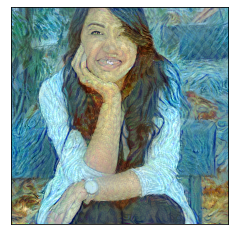

<Figure size 432x288 with 0 Axes>

In [15]:

style_image = mpimg.imread("/content/Autoportrait.jpg")
content_image = mpimg.imread("/content/oumaima.jpg")

np.random.seed(0)
nst = NST(style_image, content_image)


plt.imshow(nst.style_image[0])
plt.show()
plt.imshow(nst.content_image[0])
plt.show()

image, cost = nst.generate_image(iterations=2000, step=100, lr=0.002)
print("Best cost:", cost)

plt.imshow(image)

plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
plt.savefig('Oumaima_Style.jpg')
